# Getting Started with *earthaccess*
### Analyzing Sea Level Rise

## Overview
This tutorial analyzes global sea level rise from satellite altimetry data and compares it to a historic record. We will be reproducing the plot from this infographic: [ NASA-led Study Reveals the Causes of Sea Level Rise Since 1900](https://grace.jpl.nasa.gov/news/113/nasa-led-study-reveals-the-causes-of-sea-level-rise-since-1900/).

## Learning Objectives
- Search for data programmatically using keywords or datasets' `concept_id`
- Access data using the `earthaccess` python library
- Visualize sea level rise trends from altimetry datasets and compare against historic records

## Requirements
    
### 1. Compute environment
* This notebook can run anywhere thanks to `earthaccess`!
    
### 2. Earthdata Login
An Earthdata Login account is required to access data, as well as discover restricted data, from the NASA Earthdata system. Thus, to access NASA data, you need Earthdata Login. Please visit https://urs.earthdata.nasa.gov to register and manage your Earthdata Login account. This account is free to create and only takes a moment to set up.

### Import (or Install) Packages

In [2]:
import logging
logging.basicConfig(level=logging.INFO,
                    force = True)

try:
    import earthaccess
    import xarray as xr
    from pyproj import Geod
    import numpy as np
    import hvplot.xarray
    from matplotlib import pyplot as plt
    from pprint import pprint
    import panel as pn
    import panel.widgets as pnw
    from pqdm.threads import pqdm
except ImportError as e:
    logging.warning("installing missing dependencies... ")
    %pip install -q earthaccess matplotlib hvplot pyproj xarray numpy h5netcdf panel pqdm
finally:
    import earthaccess
    import xarray as xr
    from pyproj import Geod
    import numpy as np
    import hvplot.xarray
    from matplotlib import pyplot as plt
    from pprint import pprint
    import panel.widgets as pnw
    from pqdm.threads import pqdm
    logging.info("Dependencies imported")


INFO:root:Dependencies imported


## earthaccess and NASA's EDL

We recommend authenticating your Earthdata Login (EDL) information using the `earthaccess` python package as follows:

In [3]:
auth = earthaccess.login()

INFO:earthaccess.auth:You're now authenticated with NASA Earthdata Login


## Search for Sea Surface Height Data

Let's find the first four collections that match a keyword search for `Sea Surface Height` and print out the first two.

In [10]:
import warnings
warnings.filterwarnings('ignore')

max_results = 10

collections = earthaccess.search_datasets(
    keyword = "Fire Modified Combustion",
    #cloud_hosted = True,
    count = max_results
)

# Let's print 2 collections
for collection in collections:
    # pprint(collection.summary())
    print(pprint(collection.summary()), collection.abstract(), "\n", collection["umm"]["DOI"], "\n\n")

INFO:earthaccess.api:Datasets found: 5


{'cloud-info': {'Region': 'us-west-2',
                'S3BucketAndObjectPrefixNames': ['s3://lp-prod-protected/VJ147IMG.002',
                                                 's3://lp-prod-public/VJ147IMG.002'],
                'S3CredentialsAPIDocumentationURL': 'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentialsREADME',
                'S3CredentialsAPIEndpoint': 'https://data.lpdaac.earthdatacloud.nasa.gov/s3credentials'},
 'concept-id': 'C3365180216-LPCLOUD',
 'file-type': "[{'Media': ['HTTPS', 'Earthdata Cloud'], 'Format': 'netCDF-4', "
              "'FormatType': 'Native', 'FormatDescription': 'Network Common "
              "Data Format Version 4', 'AverageFileSize': 2.8, "
              "'AverageFileSizeUnit': 'MB', "
              "'TotalCollectionFileSizeBeginDate': "
              "'2018-01-05T00:00:00.000Z'}]",
 'get-data': ['https://search.earthdata.nasa.gov/search?q=C3365180216-LPCLOUD'],
 'short-name': 'VJ147IMG',
 'version': '002'}
None The Visible Infrared Ima

## Access Data

The first dataset looks like it contains data from many altimetry missions, let's explore a bit more! We will access the first granule of the `SEA_SURFACE_HEIGHT_ALT_GRIDS_L4_2SATS_5DAY_6THDEG_V_JPL2205` collection in the month of May for every year that data is available and open the granules via xarray.

In [13]:
granules = []

for year in range(2019, 2026):
    print(f"Searching for data in {year}")
    granule = earthaccess.search_data(doi="10.5067/VIIRS/VJ147IMG.002",
                                      temporal= (f"{year}-05", f"{year}-06"),
                                      count = 1)
    if len(granule)>0:
        granules.append(granule[0])
print(f"Total granules: {len(granules)}")

Searching for data in 2019


INFO:earthaccess.api:Granules found: 3321


Searching for data in 2020


INFO:earthaccess.api:Granules found: 3292


Searching for data in 2021


INFO:earthaccess.api:Granules found: 3258


Searching for data in 2022


INFO:earthaccess.api:Granules found: 3339


Searching for data in 2023


INFO:earthaccess.api:Granules found: 3261


Searching for data in 2024


INFO:earthaccess.api:Granules found: 3258


Searching for data in 2025


INFO:earthaccess.api:Granules found: 3324


Total granules: 7


In [ ]:
%%time

def open_file(file):
    ds = xr.open_dataset(file)
    # we can modify here
    return ds

ds_list = pqdm(earthaccess.open(granules), open_file, n_jobs=8)

ds_SSH = xr.concat(ds_list, dim="Time")
ds_SSH

## Plot Sea Level Anomalies

In [ ]:
%%time

time = pnw.Player(name='Time', start=0, end=len(ds_SSH.Time)-1, loop_policy='loop', interval=1000)

ds_SSH.SLA.interactive(loc='bottom', aspect="equal").isel(Time=time).hvplot(cmap="inferno", data_aspect=1)

## Recreate the Sea Level Rise Infographic
First, we define a function that will calculate the area in 1/6 by 1/6 degree boxes in order to calculate the global mean of the SSH later.

In [8]:
def ssl_area(lats):
    """
    Calculate the area associated with a 1/6 by 1/6 degree box at latitude specified in 'lats'.

    Parameter
    ==========
    lats: a list or numpy array of size N the latitudes of interest.

    Return
    =======
    out: Array (N) area values (unit: m^2)
    """
    # Define WGS84 as CRS:
    geod = Geod(ellps='WGS84')
    dx=1/12.0
    # create a lambda function for calculating the perimeters of the boxes
    c_area=lambda lat: geod.polygon_area_perimeter(np.r_[-dx,dx,dx,-dx], lat+np.r_[-dx,-dx,dx,dx])[0]
    out=[]
    for lat in lats:
        out.append(c_area(lat))
    return np.array(out)

Let's use the function on our Sea Surface Height dataset.

In [9]:
# note: they rotated the data in the last release, this operation used to be (1,-1)
ssh_area = ssl_area(ds_SSH.Latitude.data).reshape(-1,1)
print(ssh_area.shape)

(960, 1)


Next, we find and open the historic record dataset also using `earthaccess` and `xarray`.

In [10]:
historic_ts_results = earthaccess.search_data(short_name='JPL_RECON_GMSL')
historic_ts=xr.open_mfdataset(earthaccess.open([historic_ts_results[0]]), engine='h5netcdf')

INFO:earthaccess.api:Granules found: 1
INFO:earthaccess.store:Opening 1 granules, approx size: 0.0 GB


QUEUEING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/1 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/1 [00:00<?, ?it/s]

INFO:fsspec:BlockCache fetching block (sync) 0
INFO:fsspec:BlockCache fetching block (async) 1
INFO:fsspec:BlockCache joined background fetch without waiting.


## Let's Plot!

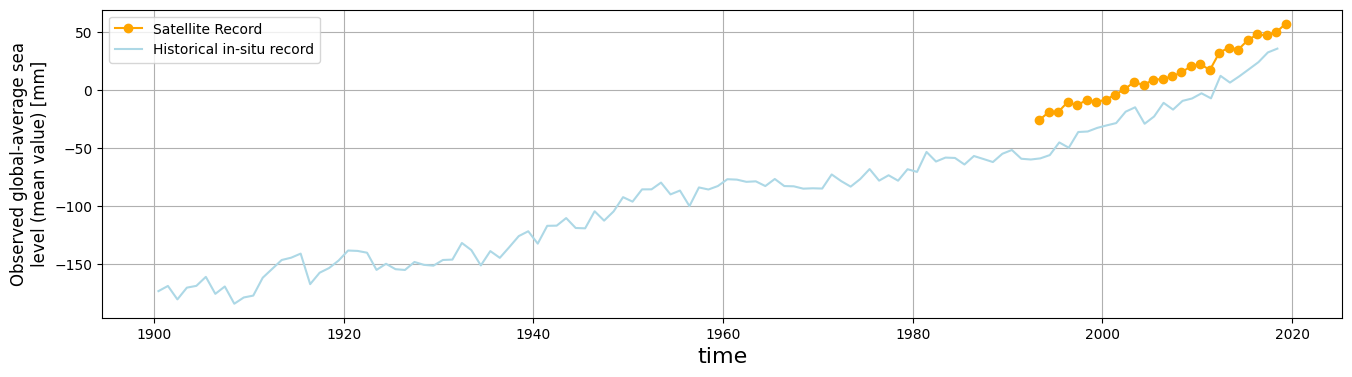

CPU times: user 722 ms, sys: 307 ms, total: 1.03 s
Wall time: 914 ms


In [11]:
%%time

plt.rcParams["figure.figsize"] = (16,4)

fig, axs = plt.subplots()
plt.grid(True)

#function to get the global mean for plotting
def global_mean(SLA, **kwargs):
    dout=((SLA*ssh_area).sum()/(SLA/SLA*ssh_area).sum())*1000
    return dout

result = ds_SSH.SLA.groupby('Time').apply(global_mean)

plt.xlabel('Time (year)',fontsize=16)
plt.ylabel('Global Mean SLA (meter)',fontsize=12)
plt.grid(True)

result.plot(ax=axs, color="orange", marker="o", label='Satellite Record')

historic_ts['global_average_sea_level_change'].plot(ax=axs, label='Historical in-situ record', color="lightblue")

plt.legend()
plt.show()

> This Data Story is based on Jinbo Wang's [Earthdata Webinar tutorial](https://github.com/betolink/the-coding-club/blob/main/notebooks/Earthdata_webinar_20220727.ipynb).